In [0]:
%pip install fast_ml
%pip install tqdm
%pip install prophet

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730984 sha256=58b746b47c588cc461632cc72223c091632c793a110bf9ccf29f282c6a83158e
  Stored in directory: /root/.cache/pip/wheels/33/3d/82/4579e9cca41ff991140b2e050bc6df3a38292f26e4fa06b15d
Successfully built pymeeus
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-40b4fe34-6065-4b82-8935-48e367fdc849
    Can't uninstall 'numpy'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.1 requires numpy<1.

In [0]:
import pandas as pd
import tqdm
import numpy as np
import matplotlib.pyplot as plt  
from datetime import datetime
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import IsolationForest

/databricks/python/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [0]:
df = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/after_covid_daily.csv", parse_dates=['ds'])
df_covid = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/Covid.csv")

In [0]:
activations = df[['ds', 'simulated']]
activations = activations.rename(columns={'simulated':'y'})
activations['ds'] = pd.to_datetime(activations['ds'])
activations_index = activations.set_index(['ds'])
activations_index.head()

,y
ds,
2022-03-01 00:00:00+00:00,3007
2022-03-02 00:00:00+00:00,3313
2022-03-03 00:00:00+00:00,2827
2022-03-04 00:00:00+00:00,2974
2022-03-05 00:00:00+00:00,2914


In [0]:
activations_index = activations_index.resample('D').sum().ffill()
activations_index.head()

,y
ds,
2022-03-01 00:00:00+00:00,3007
2022-03-02 00:00:00+00:00,3313
2022-03-03 00:00:00+00:00,2827
2022-03-04 00:00:00+00:00,2974
2022-03-05 00:00:00+00:00,2914


In [0]:
print(len(activations_index))

214


In [0]:
after_covid_df = activations_index.reset_index()
after_covid_df['ds'] = pd.date_range(start='2022-03-01', periods=len(activations_index), freq='D') ##config the time index to fit in prophet ds

## Baseline Model

In [0]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

13:45:21 - cmdstanpy - INFO - Chain [1] start processing
13:45:21 - cmdstanpy - INFO - Chain [1] done processing


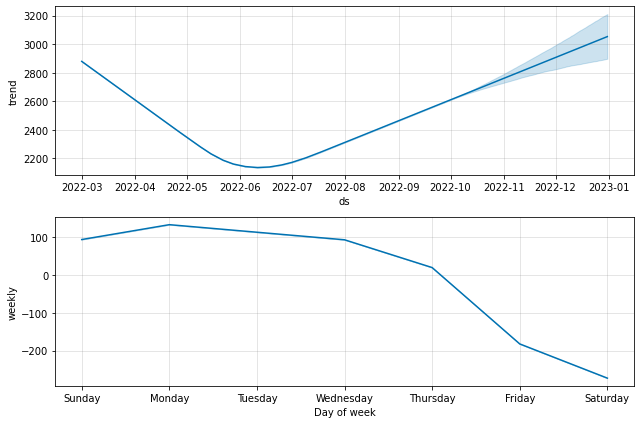

In [0]:
m = Prophet(
  # yearly_seasonality= False, 
  #                       weekly_seasonality= 'auto',
  #                       changepoint_prior_scale= 0.05,
  #                       seasonality_prior_scale=10,
  #                       holidays_prior_scale=0.1,
  #                       seasonality_mode = 'multiplicative'
                        )

m.fit(after_covid_df)

future = m.make_future_dataframe(92, freq='D')
forecast = m.predict(future)

fig = m.plot_components(forecast)

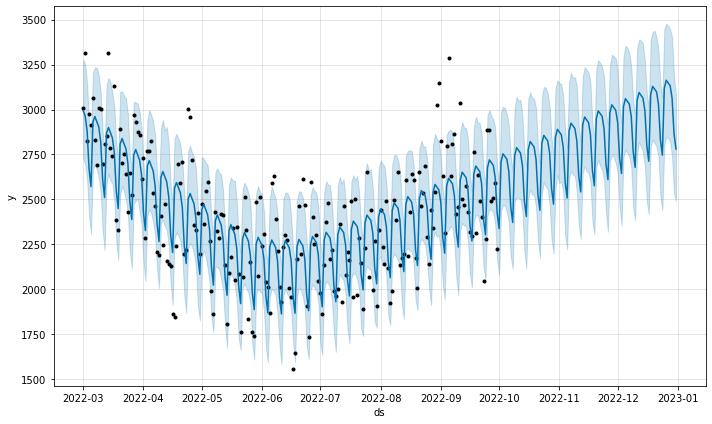

In [0]:
m.plot(forecast, uncertainty=True)
plt.show()

In [0]:
# Initial training period.
initial= 170
initial= str(initial)+' days'

#Period length that we perform the cross validation for.
period= 40
period=str(period)+' days'

#Horizon of prediction essentially for each fold.
horizon = 30
horizon=str(horizon)+' days'
fb_cv=cross_validation(m,initial=initial,period=period,
horizon=horizon)

# Performance Metrics of fb_cv
cv = performance_metrics(fb_cv)
cv.head()

  0%|          | 0/1 [00:00<?, ?it/s]

13:45:22 - cmdstanpy - INFO - Chain [1] start processing
13:45:22 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,100279.426327,316.669270,299.837433,0.113433,0.134501,0.120880,0.333333
1,4 days,80680.797027,284.043653,270.667629,0.103396,0.104389,0.109526,0.333333
2,5 days,203742.540390,451.378489,385.473447,0.129117,0.104389,0.140498,0.333333
3,6 days,196239.658330,442.989456,347.784129,0.112105,0.104389,0.122747,0.333333
4,7 days,187815.013585,433.376296,332.105579,0.106400,0.087273,0.116453,0.666667


In [0]:
cv.mean()

Out[11]: horizon     16 days 12:00:00
mse             64713.377255
rmse              230.484058
mae               198.936621
mape                0.074729
mdape                0.07301
smape               0.076893
coverage            0.678571
dtype: object

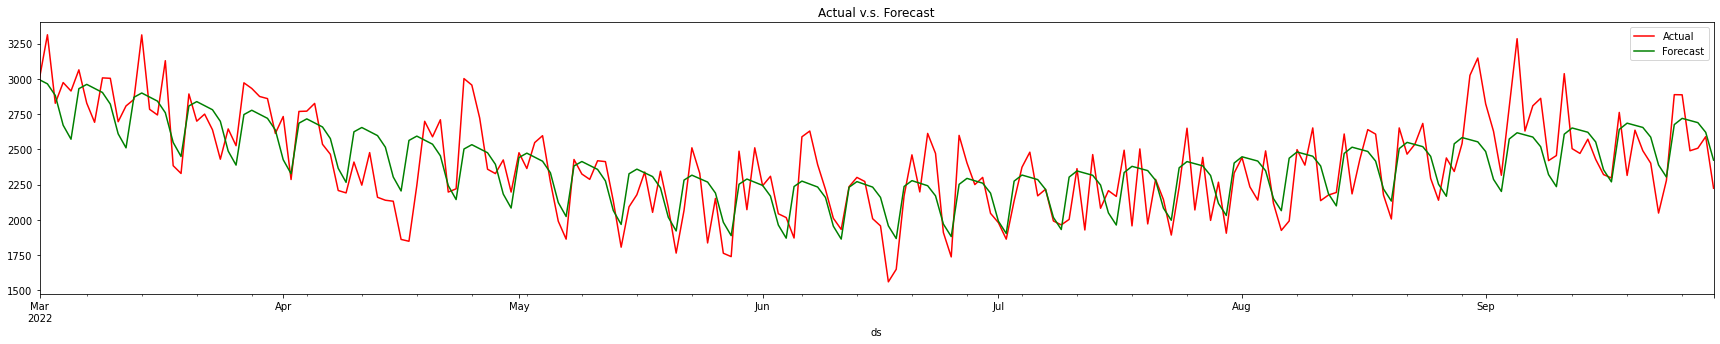

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

actual_index = after_covid_df.set_index(['ds'])
forecast_index = forecast.set_index(['ds']).iloc[:214]

actual_index['y'].plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
forecast_index['yhat'].plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Actual v.s. Forecast')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = actual_index['y']
y_pred = forecast_index['yhat']

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

mape: 0.0722923604828889
r2: 0.6099762866463494
RMSE 214.35828750232488


##Adding Seasonality Mode, Seasonal Parameters, and Holidays

In [0]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    #'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    #'holidays_prior_scale': [0.1, 1.0, 5.0, 10],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_country_holidays(country_name='DE')

    m.add_seasonality('quarterly', period=91.25, fourier_order=5, mode='multiplicative')
    m.add_seasonality('weekly', period=7, fourier_order=10, mode='multiplicative')

    m.add_seasonality(name='yearly_on_season', period=365, fourier_order=10, condition_name='on_season', mode='multiplicative')
    m.add_seasonality(name='yearly_off_season', period=365, fourier_order=10, condition_name='off_season', mode='multiplicative')

    m.fit(after_covid_df)  # Fit model with given params

    df_cv = cross_validation(m, initial='170 days', period='40 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<command-680409974059500> in <cell line: 17>()
     25     m.add_seasonality(name='yearly_off_season', period=365, fourier_order=10, condition_name='off_season', mode='multiplicative')
     26 
---> 27     m.fit(after_covid_df)  # Fit model with given params
     28 
     29     df_cv = cross_validation(m, initial='170 days', period='40 days', horizon='30 days', parallel="processes")

/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5fd2b21-9161-4786-867c-1fa8356732e7/lib/python3.9/site-packages/prophet/forecaster.py in fit(self, df, **kwargs)
   1117         self.history_dates = pd.to_datetime(pd.Series(df['ds'].unique(), name='ds')).sort_values()
   1118 
-> 1119         history = self.setup_dataframe(history, initialize_scales=True)
   1120         self.history = history
   1121         self.set_auto_seasonalities()

/local_disk0/.ephemer

In [0]:
best_params = all_params[np.argmin(mape)]
print(best_params)

In [0]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9 or date.month <= 6)

after_covid_df['on_season'] = after_covid_df['ds'].apply(is_nfl_season)
after_covid_df['off_season'] = ~after_covid_df['ds'].apply(is_nfl_season)

In [0]:
m = Prophet(
            # yearly_seasonality= False, 
            # weekly_seasonality= 'auto',
            # changepoint_prior_scale= 0.01,
            seasonality_prior_scale=0.01,
            #holidays_prior_scale=5.0,
            seasonality_mode = 'additive'
                        )
#m.add_country_holidays(country_name='DE')

m.add_seasonality('quarterly', period=91.25, fourier_order=5, mode='additive')
#m.add_seasonality('weekly', period=7, fourier_order=10, mode='multiplicative')

m.add_seasonality(name='yearly_on_season', period=365, fourier_order=10, condition_name='on_season', mode='multiplicative')
m.add_seasonality(name='yearly_off_season', period=365, fourier_order=10, condition_name='off_season', mode='multiplicative')

m.fit(after_covid_df)

future = m.make_future_dataframe(92, freq='D')
future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.predict(future)

fig = m.plot_components(forecast)

In [0]:
m.plot(forecast, uncertainty=True)
plt.show()

In [0]:
# Initial training period.
initial= 170
initial= str(initial)+' days'

#Period length that we perform the cross validation for.
period= 40
period=str(period)+' days'

#Horizon of prediction essentially for each fold.
horizon = 30
horizon=str(horizon)+' days'
fb_cv=cross_validation(m,initial=initial,period=period,
horizon=horizon)

# Performance Metrics of fb_cv
cv = performance_metrics(fb_cv)

In [0]:
cv.mean()

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

actual_index = after_covid_df.set_index(['ds'])
forecast_index = forecast.set_index(['ds']).iloc[:214]

actual_index['y'].plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
forecast_index['yhat'].plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Actual v.s. Forecast')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = actual_index['y']
y_pred = forecast_index['yhat']

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

##Adding Change Parameters

In [0]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    #'holidays_prior_scale': [0.1, 1.0, 5.0, 10],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_country_holidays(country_name='DE')
    m.fit(after_covid_df)  # Fit model with given params

    df_cv = cross_validation(m, initial='170 days', period='40 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results)

In [0]:
best_params = all_params[np.argmin(mape)]
print(best_params)

In [0]:
m_changepoints = (
    pd.date_range('2022-03-01', '2022-03-31', periods=4).date.tolist() + 
    pd.date_range('2022-09-01', '2022-09-30', periods=4).date.tolist()
)

In [0]:
m = Prophet(
            # yearly_seasonality= False, 
            # weekly_seasonality= 'auto',
            changepoint_prior_scale= 0.05,
            seasonality_prior_scale=0.01,
            #holidays_prior_scale=5.0,
            seasonality_mode = 'additive'
                        )
#m.add_country_holidays(country_name='DE')

m.add_seasonality('quarterly', period=91.25, fourier_order=5, mode='additive')
#m.add_seasonality('weekly', period=7, fourier_order=10, mode='multiplicative')

m.add_seasonality(name='yearly_on_season', period=365, fourier_order=10, condition_name='on_season', mode='multiplicative')
m.add_seasonality(name='yearly_off_season', period=365, fourier_order=10, condition_name='off_season', mode='multiplicative')

m.fit(after_covid_df)

future = m.make_future_dataframe(92, freq='D')
future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.predict(future)

fig = m.plot_components(forecast)

In [0]:
m.plot(forecast, uncertainty=True)
plt.show()

In [0]:
# Initial training period.
initial= 170
initial= str(initial)+' days'

#Period length that we perform the cross validation for.
period= 40
period=str(period)+' days'

#Horizon of prediction essentially for each fold.
horizon = 30
horizon=str(horizon)+' days'
fb_cv=cross_validation(m,initial=initial,period=period,
horizon=horizon)

# Performance Metrics of fb_cv
cv = performance_metrics(fb_cv)
cv.head()

cv.mean()

##with holiday is 0.167997

In [0]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

actual_index = after_covid_df.set_index(['ds'])
forecast_index = forecast.set_index(['ds']).iloc[:214]

actual_index['y'].plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
forecast_index['yhat'].plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Actual v.s. Forecast')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = actual_index['y']
y_pred = forecast_index['yhat']

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

## Adding Holidays

In [0]:
real_holidays = pd.DataFrame({
  'holiday': 'real_holidays',
  'ds': pd.to_datetime(['2022-04-14', '2022-12-25']),
  'lower_window': -7,
  'upper_window': 7,
})
vacations = pd.DataFrame({
  'holiday': 'vacations',
  'ds': pd.to_datetime(['2022-07-05', '2022-08-05']),
  'lower_window': -30,
  'upper_window': 30,
})
compaigns = pd.DataFrame({
  'holiday': 'compaigns',
  'ds': pd.to_datetime(['2022-03-01', '2022-09-01']),
  'lower_window': 0,
  'upper_window': 15,
})
holidays = pd.concat((real_holidays, vacations, compaigns))

In [0]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9 or date.month <= 6)

after_covid_df['on_season'] = after_covid_df['ds'].apply(is_nfl_season)
after_covid_df['off_season'] = ~after_covid_df['ds'].apply(is_nfl_season)

17:22:59 - cmdstanpy - INFO - Chain [1] start processing
17:22:59 - cmdstanpy - INFO - Chain [1] done processing


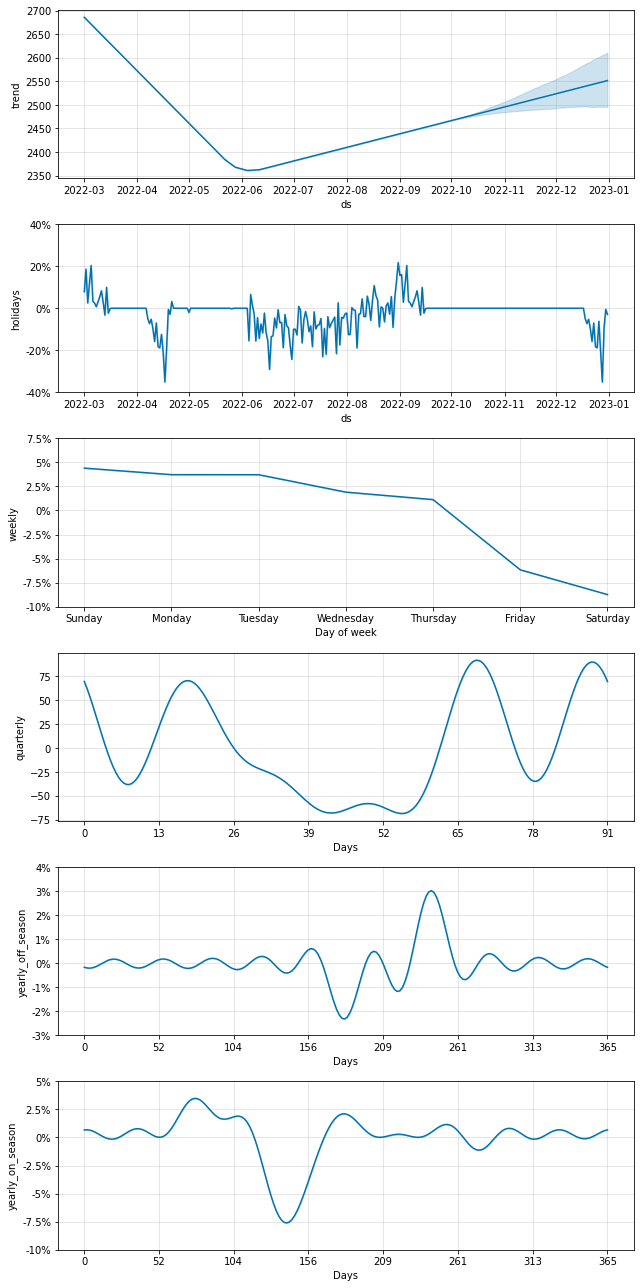

In [0]:
m = Prophet(
            #yearly_seasonality= False, 
            #weekly_seasonality= 'auto',
            changepoint_prior_scale= 0.05,
            seasonality_prior_scale=0.01,
            holidays_prior_scale=5,
            holidays= holidays,
            seasonality_mode = 'multiplicative'
                        )
m.add_country_holidays(country_name='DE')

m.add_seasonality('quarterly', period=91.25, fourier_order=5, mode='additive')
#m.add_seasonality('weekly', period=7, fourier_order=10, mode='multiplicative')

m.add_seasonality(name='yearly_on_season', period=365, fourier_order=10, condition_name='on_season', mode='multiplicative')
m.add_seasonality(name='yearly_off_season', period=365, fourier_order=10, condition_name='off_season', mode='multiplicative')

m.fit(after_covid_df)

future = m.make_future_dataframe(92, freq='D')
future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)

forecast = m.predict(future)

fig = m.plot_components(forecast)

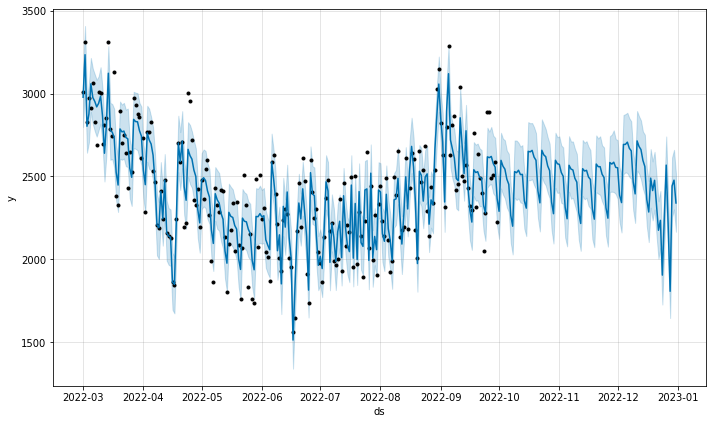

In [0]:
m.plot(forecast, uncertainty=True)
plt.show()

In [0]:
# Initial training period.
initial= 170
initial= str(initial)+' days'

#Period length that we perform the cross validation for.
period= 30
period=str(period)+' days'

#Horizon of prediction essentially for each fold.
horizon = 30
horizon=str(horizon)+' days'
fb_cv=cross_validation(m,initial=initial,period=period,
horizon=horizon)

# Performance Metrics of fb_cv
cv = performance_metrics(fb_cv)
cv.head()

cv.mean()

##with add seasonality is 0.15371

Seasonality has period of 365 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/1 [00:00<?, ?it/s]

17:23:02 - cmdstanpy - INFO - Chain [1] start processing
17:23:02 - cmdstanpy - INFO - Chain [1] done processing
Out[12]: horizon     16 days 12:00:00
mse             62739.170957
rmse               233.94557
mae               199.353706
mape                0.074462
mdape               0.069705
smape               0.076186
coverage            0.571429
dtype: object

In [0]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
301,2022-12-27,2203.796659,2022.556899,2384.619405
302,2022-12-28,1807.631621,1646.212819,1993.240771
303,2022-12-29,2442.908809,2254.867674,2614.876835
304,2022-12-30,2477.749495,2301.173914,2660.879193
305,2022-12-31,2340.110806,2166.633550,2515.997048


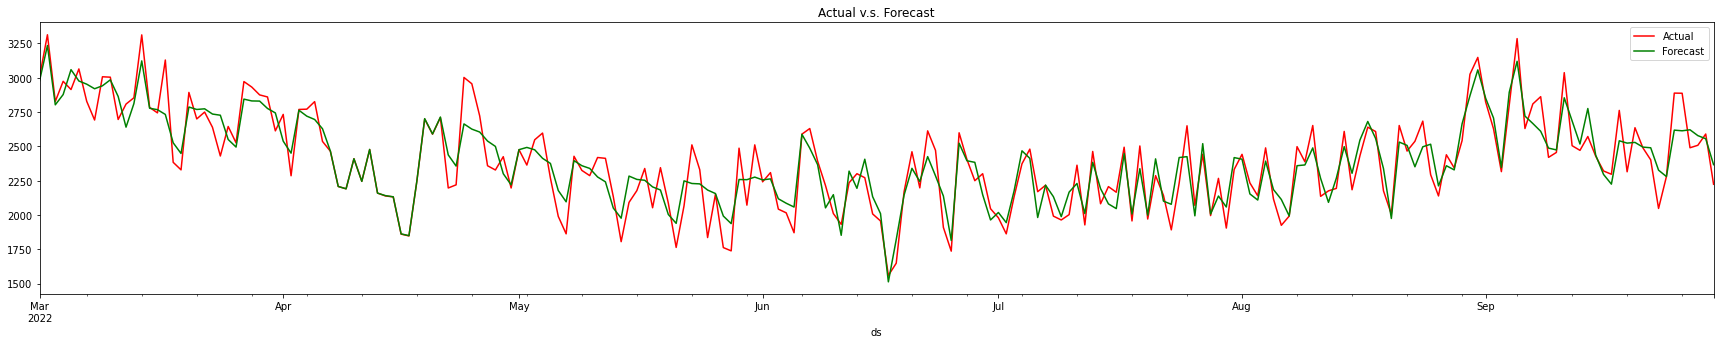

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

actual_index = after_covid_df.set_index(['ds'])
forecast_index = forecast.set_index(['ds']).iloc[:214]

actual_index['y'].plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
forecast_index['yhat'].plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Actual v.s. Forecast')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = actual_index['y']
y_pred = forecast_index['yhat']

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

mape: 0.04524650621202451
r2: 0.8500769941206168
RMSE 132.90120324287776


#DO

In [0]:
future_real = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/D_Input_new.csv", parse_dates=['ds'])
future_real = future_real[['ds', 'simulated']]
future_real.head()

,ds,simulated
0,2022-09-01 00:00:00+00:00,3234
1,2022-09-02 00:00:00+00:00,2801
2,2022-09-03 00:00:00+00:00,2642
3,2022-09-04 00:00:00+00:00,2884
4,2022-09-05 00:00:00+00:00,3115


In [0]:
future_real_df = future_real[future_real['ds'] >= '2022-10-01']
future_real_df_index = future_real_df.set_index(['ds'])
future_real_df_index

,simulated
ds,
2022-10-01 00:00:00+00:00,2370
2022-10-02 00:00:00+00:00,2355
2022-10-03 00:00:00+00:00,3068
2022-10-04 00:00:00+00:00,2640
2022-10-05 00:00:00+00:00,2602
2022-10-06 00:00:00+00:00,2598
2022-10-07 00:00:00+00:00,2331
2022-10-08 00:00:00+00:00,2491
2022-10-09 00:00:00+00:00,2860


In [0]:
forecast_df = forecast[['ds', 'yhat']]
forecast_df = forecast_df[forecast_df['ds'] >= '2022-10-01']
forecast_df = forecast_df[forecast_df['ds'] < '2022-11-27'].set_index(['ds'])
forecast_df

,yhat
ds,
2022-10-01,2289.975886
2022-10-02,2597.163072
2022-10-03,2562.256364
2022-10-04,2544.269568
2022-10-05,2483.756578
2022-10-06,2452.538370
2022-10-07,2265.132589
2022-10-08,2200.125314
2022-10-09,2529.374847


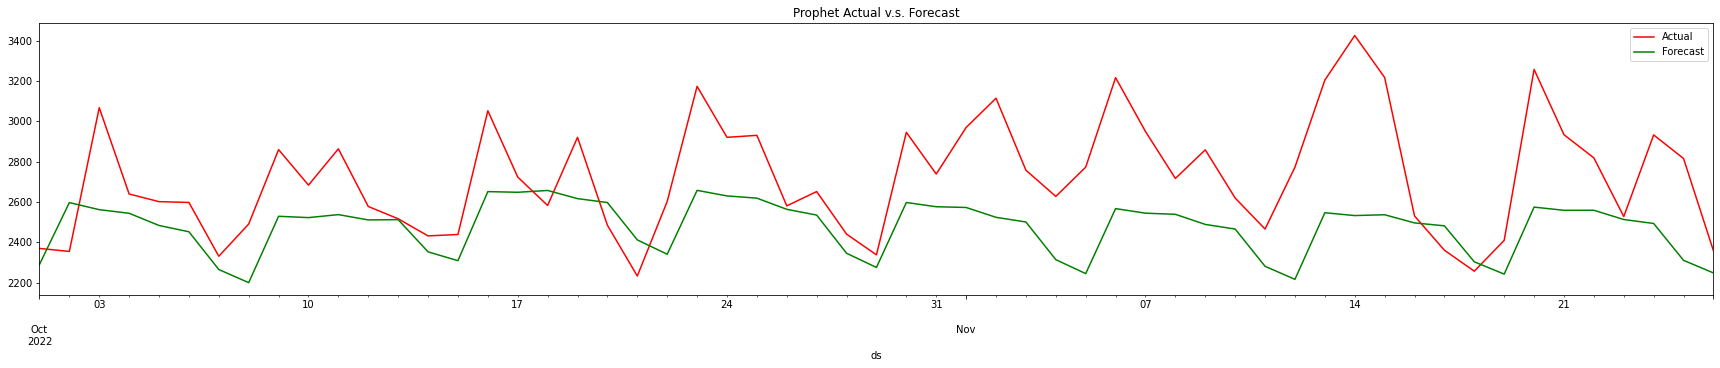

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

future_real_df_index.plot(kind='line',y='simulated', color='red', label='Actual', ax=ax)
forecast_df.plot(kind='line',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Prophet Actual v.s. Forecast')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = future_real_df_index
y_pred = forecast_df

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

mape: 0.09484481657189597
r2: -0.4506721150747226
RMSE 342.1249837024356
